<a href="https://colab.research.google.com/github/GabEscom/ROBOT_TRADING_ALURA/blob/main/Crude_Robot_Trading_Gab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<font color=cyan>**1. Configuración del Ambiente**


In [ ]:
pip install matplotlib


In [ ]:
pip install yfinance

In [4]:
# Bibliotecas
import sys
import bs4
from urllib.request import urlopen, urlretrieve, Request
import requests
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
from IPython.display import clear_output
import time
from datetime import datetime


##<font color=cyan>**2. Obtención de datos**

In [5]:
## Importar base de datos de petróleo crudo

def importar_base_crudo():
  global df_cl
  df_cl= yf.download("CL=F", interval="15m", period="7d")


In [6]:
importar_base_crudo()
df_cl.sort_index(inplace=True, ascending=False)
df_cl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-31 21:00:00,81.160004,81.480003,81.120003,81.419998,81.419998,1883
2023-10-31 20:45:00,81.160004,81.199997,81.080002,81.169998,81.169998,467
2023-10-31 20:30:00,81.290001,81.330002,81.160004,81.169998,81.169998,374
2023-10-31 20:15:00,81.260002,81.370003,81.250000,81.290001,81.290001,355
2023-10-31 20:00:00,81.349998,81.379997,81.260002,81.260002,81.260002,1007


In [8]:
def extraer_tendencia():
  global precio_actual, tendencia
  ## Importar datos desde https://investing.com/
  url='https://www.investing.com/commodities/crude-oil'
  response = requests.get(url)
  soup = BeautifulSoup(response.content, features='lxml')

  ## Obtener Precio actual

  price=soup.find('div', {'class':['flex flex-wrap gap-x-4 gap-y-2 items-center md:gap-6 mb-3']}).getText()
  precio_actual=float(price.split('+')[0].split('-')[0])

  ## Obtener tendencia
  tendencia = 'subida' if '+' in price else 'bajada'


In [9]:
extraer_tendencia()
print('Precio Crudo (USD/BBL): ', precio_actual)
print('Tendencia: ', tendencia)

Precio Crudo (USD/BBL):  81.39
Tendencia:  subida


##<font color=cyan>**3. Limpieza de datos**

In [10]:
df_cl.shape[0]

541

In [11]:
# Copia del df
df_cl_limpio = df_cl.copy()

# Filtrar valores unicos en el índice
df_cl_limpio.index = pd.to_datetime(df_cl_limpio.index)
df_cl_limpio = df_cl_limpio[~df_cl_limpio.index.duplicated(keep='first')]
#df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates(subset=['Datetime'], keep='first')

df_cl_limpio.shape[0]


541

In [12]:
# Eliminar valores nulos de la columna 'Close'
df_cl_limpio=df_cl_limpio.dropna(subset=['Close'])
df_cl_limpio.shape[0]

541

In [13]:
# Filtrar valores de 'Volume' superiores a cero
df_cl_limpio = df_cl_limpio[df_cl_limpio['Volume'] > 0]
df_cl_limpio.shape[0]

541

<Axes: >

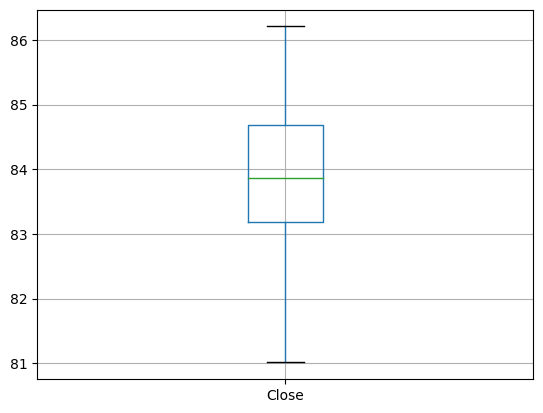

In [14]:
# identificar outliers
df_cl.boxplot(['Close'])

<Axes: >

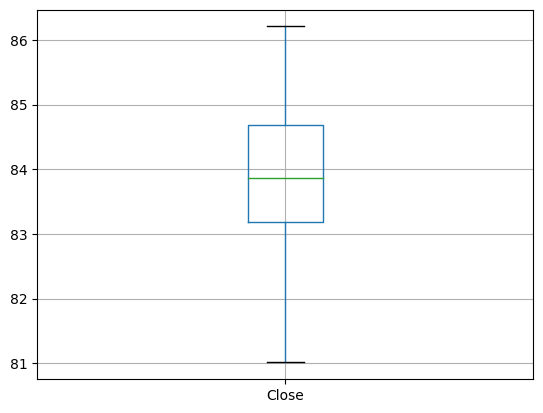

In [15]:
# Remover outliers
cierre= df_cl_limpio['Close']
Q1 = cierre.quantile(0.25)
Q3 = cierre.quantile(0.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
seleccion=(cierre > limite_inferior) & (cierre < limite_superior)
df_cl_limpio = df_cl_limpio[seleccion]
df_cl_limpio.boxplot(['Close'])

In [16]:
# Calcular el valor promedio de los valores de la columna 'Close'
media_crudo = df_cl_limpio['Close'].mean()
media_crudo

83.89643256280867

In [20]:
def limpieza_datos():
    global media_crudo
    # Copia del df
    df_cl_limpio = df_cl.copy()

    # Filtrar valores unicos en el índice
    df_cl_limpio.index = pd.to_datetime(df_cl_limpio.index)
    df_cl_limpio = df_cl_limpio[~df_cl_limpio.index.duplicated(keep='first')]

    # Eliminar valores nulos de la columna 'Close'
    df_cl_limpio=df_cl_limpio.dropna(subset=['Close'])

    # Filtrar valores de 'Volume' superiores a cero
    df_cl_limpio = df_cl_limpio[df_cl_limpio['Volume'] > 0]

    # identificar y remover outliers
    cierre= df_cl_limpio['Close']
    Q1 = cierre.quantile(0.25)
    Q3 = cierre.quantile(0.75)
    IIQ = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IIQ
    limite_superior = Q3 + 1.5 * IIQ
    seleccion=(cierre > limite_inferior) & (cierre < limite_superior)
    df_cl_limpio = df_cl_limpio[seleccion]

    # Calcular el valor promedio de los valores de la columna 'Close'
    media_crudo = df_cl_limpio['Close'].mean()


In [28]:
limpieza_datos()
print('Precio Promedio Crudo (USD/BBL): ', media_crudo)

Precio Promedio Crudo (USD/BBL):  83.89643256280867


##<font color=cyan>**4. Tomar decisiones**

In [25]:
def tomar_decisiones():
  global algoritmo_decision

  algoritmo_decision = ()

  if precio_actual >= media_crudo and tendencia == 'bajada':
        algoritmo_decision = 'Vender'
  elif precio_actual < media_crudo and tendencia == 'subida':
       algoritmo_decision = 'Comprar'
  else:
        algoritmo_decision = 'Esperar'



In [27]:
tomar_decisiones()
print('Decición: ', algoritmo_decision)

Decición:  Comprar


##<font color=cyan>**5. Visualización**

In [34]:
def visualizacion():

  # Adicionar una nueva columna "Promedio"
  df_cl['Promedio'] = media_crudo

  # Configurar el tamaño del gráfico y Título
  plt.figure(figsize=(16, 5))
  plt.title('Robot Trading')

  # Dibujar una línea con los datos del índice y la columna 'Close'
  plt.plot(df_cl.index, df_cl['Close'], label='Precio de Cierre', color='b')

  # Dibujar una línea con los datos del índice y la columna 'Promedio'

  plt.plot(df_cl.index, df_cl['Promedio'], label='Promedio', color='r')

  # Resaltar el último precio de cierre con un marcador circular
  ultimo_valor = df_cl['Close'].iloc[-1]
  plt.scatter(df_cl.index[-1], ultimo_valor, color='b', s=100, zorder=3)
  plt.text(df_cl.index[-1], ultimo_valor, f'{ultimo_valor:.2f}', color='black', fontsize=12, ha='left', va='center')

  # Mostrar un mensaje con la decisión del algoritmo en el gráfico

  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(0.90, 0.90), xycoords='axes fraction', ha='center', fontsize=12)

  print("Hora de ejecución:", datetime.now())
  print('Precio Promedio Crudo: ', media_crudo)
  print('Precio Actual Crudo: ', precio_actual)
  print('Tendencia: ', tendencia)
  plt.show()

Hora de ejecución: 2023-11-01 03:08:01.776825
Precio Promedio Crudo:  83.88709027200773
Precio Actual Crudo:  81.23
Tendencia:  subida


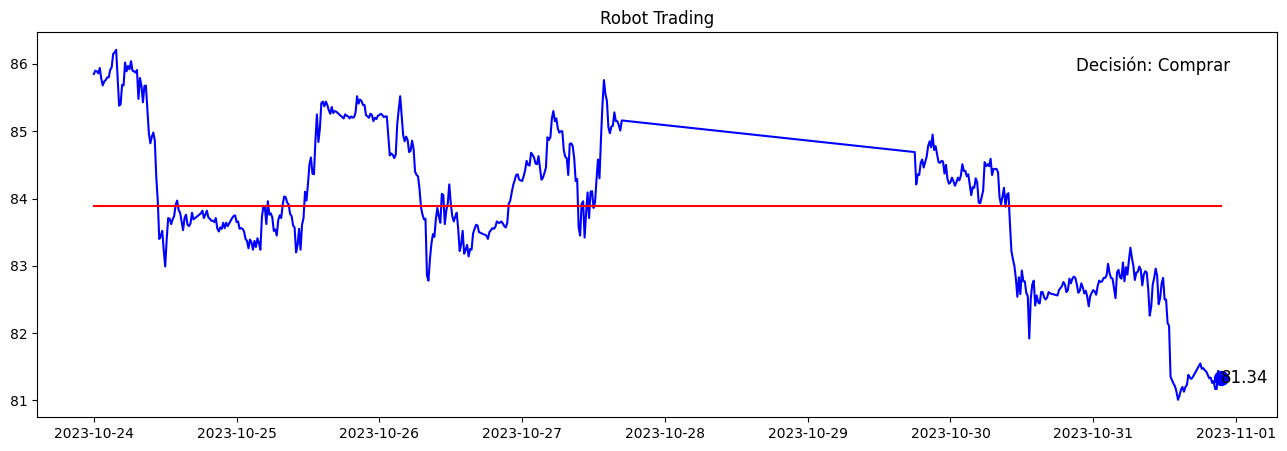

In [35]:
visualizacion()

##<font color=cyan>**6. Automatización**

[*********************100%%**********************]  1 of 1 completed
Hora de ejecución: 2023-11-01 01:48:53.710099
Precio Promedio Crudo:  83.88709027200773
Precio Actual Crudo:  81.23
Tendencia:  subida


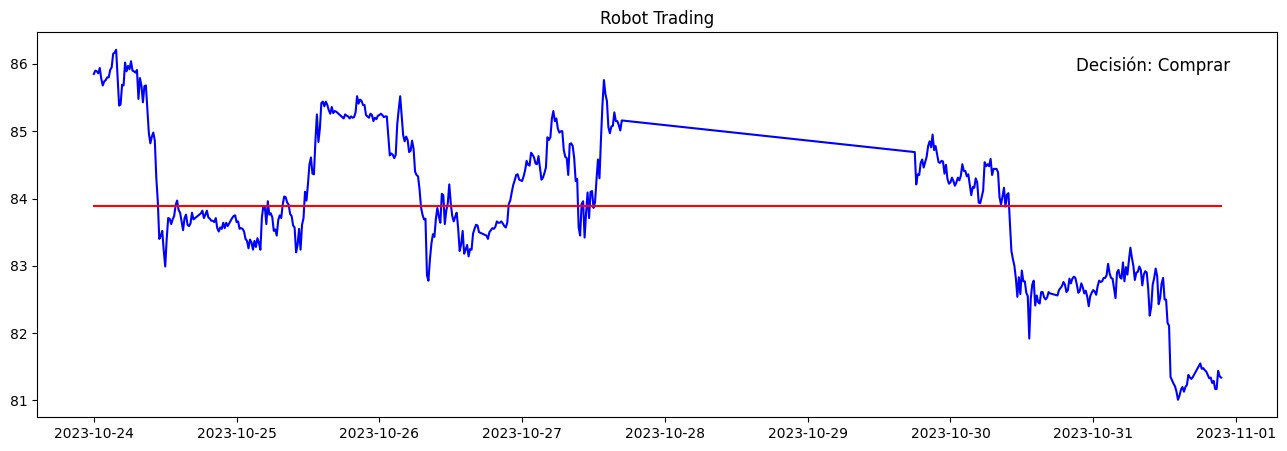

KeyboardInterrupt: ignored

In [33]:
while(True):
  clear_output()
  importar_base_crudo()
  extraer_tendencia()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)